In [20]:
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Load data
df = pd.read_csv('MMM_test_data.csv')
df['start_of_week'] = pd.to_datetime(df['start_of_week'], format='%d-%m-%y')

spend_cols = [col for i, col in enumerate(df.filter(like='spend').columns) if i != 1]  # Exclude channel 2
n_channels = len(spend_cols)

# Time features for seasonality
df['week_of_year'] = df['start_of_week'].dt.isocalendar().week
n_weeks = len(df)

# Time index for linear trend 
time_idx = np.arange(n_weeks, dtype='float32')

# Prepare data tensors
spend_data = df[spend_cols].values.astype('float32')
revenue_data = df['revenue'].values.astype('float32')
week_of_year = df['week_of_year'].values.astype('int32')


def geometric_adstock(spend_series, alpha, l_max):
    # Calculate retention weights
    weights = alpha ** pt.arange(l_max, dtype='float32')
    weights /= pt.sum(weights)
    
    # Pad the spend series with zeros for lookback
    padded = pt.concatenate([pt.zeros(l_max-1, dtype='float32'), spend_series])
    
    # Create indices for all time steps
    time_steps = spend_series.shape[0]
    t = pt.arange(time_steps)
    
    # Create a matrix of all windows at once
    windows = padded[t[:, None] + pt.arange(l_max)]
    
    # Reverse each window and multiply by weights
    adstock = pt.sum(windows[:, ::-1] * weights, axis=1)
    
    return adstock

In [17]:
with pm.Model() as mmm:
    # Priors
    base = pm.Normal('base', mu=revenue_data.mean(), sigma=10)  # Base
    beta = pm.HalfNormal('beta', sigma=10, shape=n_channels)  # Effectiveness
    alpha = pm.Beta('alpha', alpha=2, beta=2, shape=n_channels)  # Adstock retention
    trend_slope = pm.Normal('trend_slope', mu=0, sigma=10)
    trend = pm.Deterministic('trend', trend_slope * time_idx)

    # Seasonal frequencies
    beta_sin1 = pm.Normal('beta_sin1', mu=0, sigma=1)
    beta_cos1 = pm.Normal('beta_cos1', mu=0, sigma=1)
    beta_sin2 = pm.Normal('beta_sin2', mu=0, sigma=1)
    beta_cos2 = pm.Normal('beta_cos2', mu=0, sigma=1)

    freq1 = 2 * np.pi / 52  # Annual
    freq2 = 2 * np.pi / 26  # Semi-annual

    seasonality = (beta_sin1 * pt.sin(freq1 * week_of_year) + 
        beta_cos1 * pt.cos(freq1 * week_of_year) +
        beta_sin2 * pt.sin(freq2 * week_of_year) + 
        beta_cos2 * pt.cos(freq2 * week_of_year))
    
    # Adstock transformation
    adstocked = pt.stack([
        geometric_adstock(spend_data[:, i], alpha[i], l_max=8)
        for i in range(n_channels)
    ], axis=1)
    
    media_contribution = pt.dot(adstocked, beta)

	# Main equation
    mu = base + media_contribution + trend + seasonality
    
    sigma = pm.HalfNormal('sigma', sigma=1)  # Noise
    pm.Normal('revenue', mu=mu, sigma=sigma, observed=revenue_data)
    
    # Sample
    trace = pm.sample(
        draws=4000,
        tune=2000,
        cores=4,
        target_accept=0.95,
        idata_kwargs={'log_likelihood': True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base, beta, alpha, trend_slope, beta_sin1, beta_cos1, beta_sin2, beta_cos2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 96 seconds.


In [ ]:
pm.model_to_graphviz(mmm)

Sampling: [revenue]


Output()

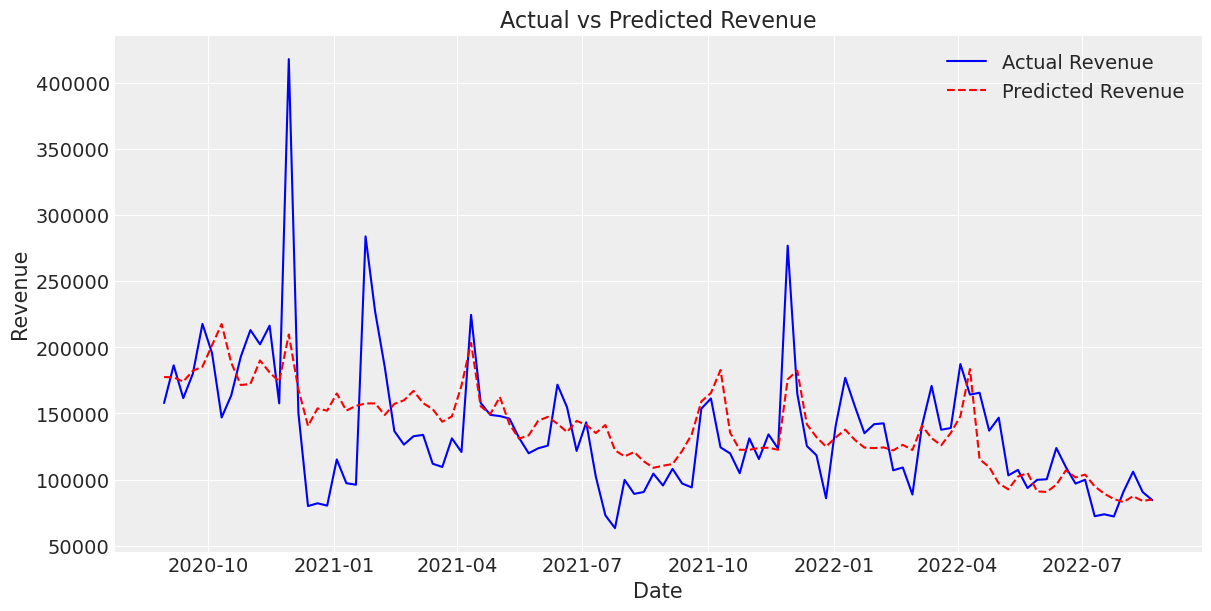

In [18]:
import matplotlib.pyplot as plt

# Get posterior predictive samples
with mmm:
    ppc = pm.sample_posterior_predictive(trace)

# Calculate mean predicted revenue across all samples
predicted_revenue = ppc.posterior_predictive['revenue'].mean(axis=(0, 1)).values

# Create time index for plotting
dates = df['start_of_week']

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(dates, revenue_data, 'b-', label='Actual Revenue')
plt.plot(dates, predicted_revenue, 'r--', label='Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

/home/emre/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (123), generating only 20 plots
  warnings.warn(
/home/emre/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


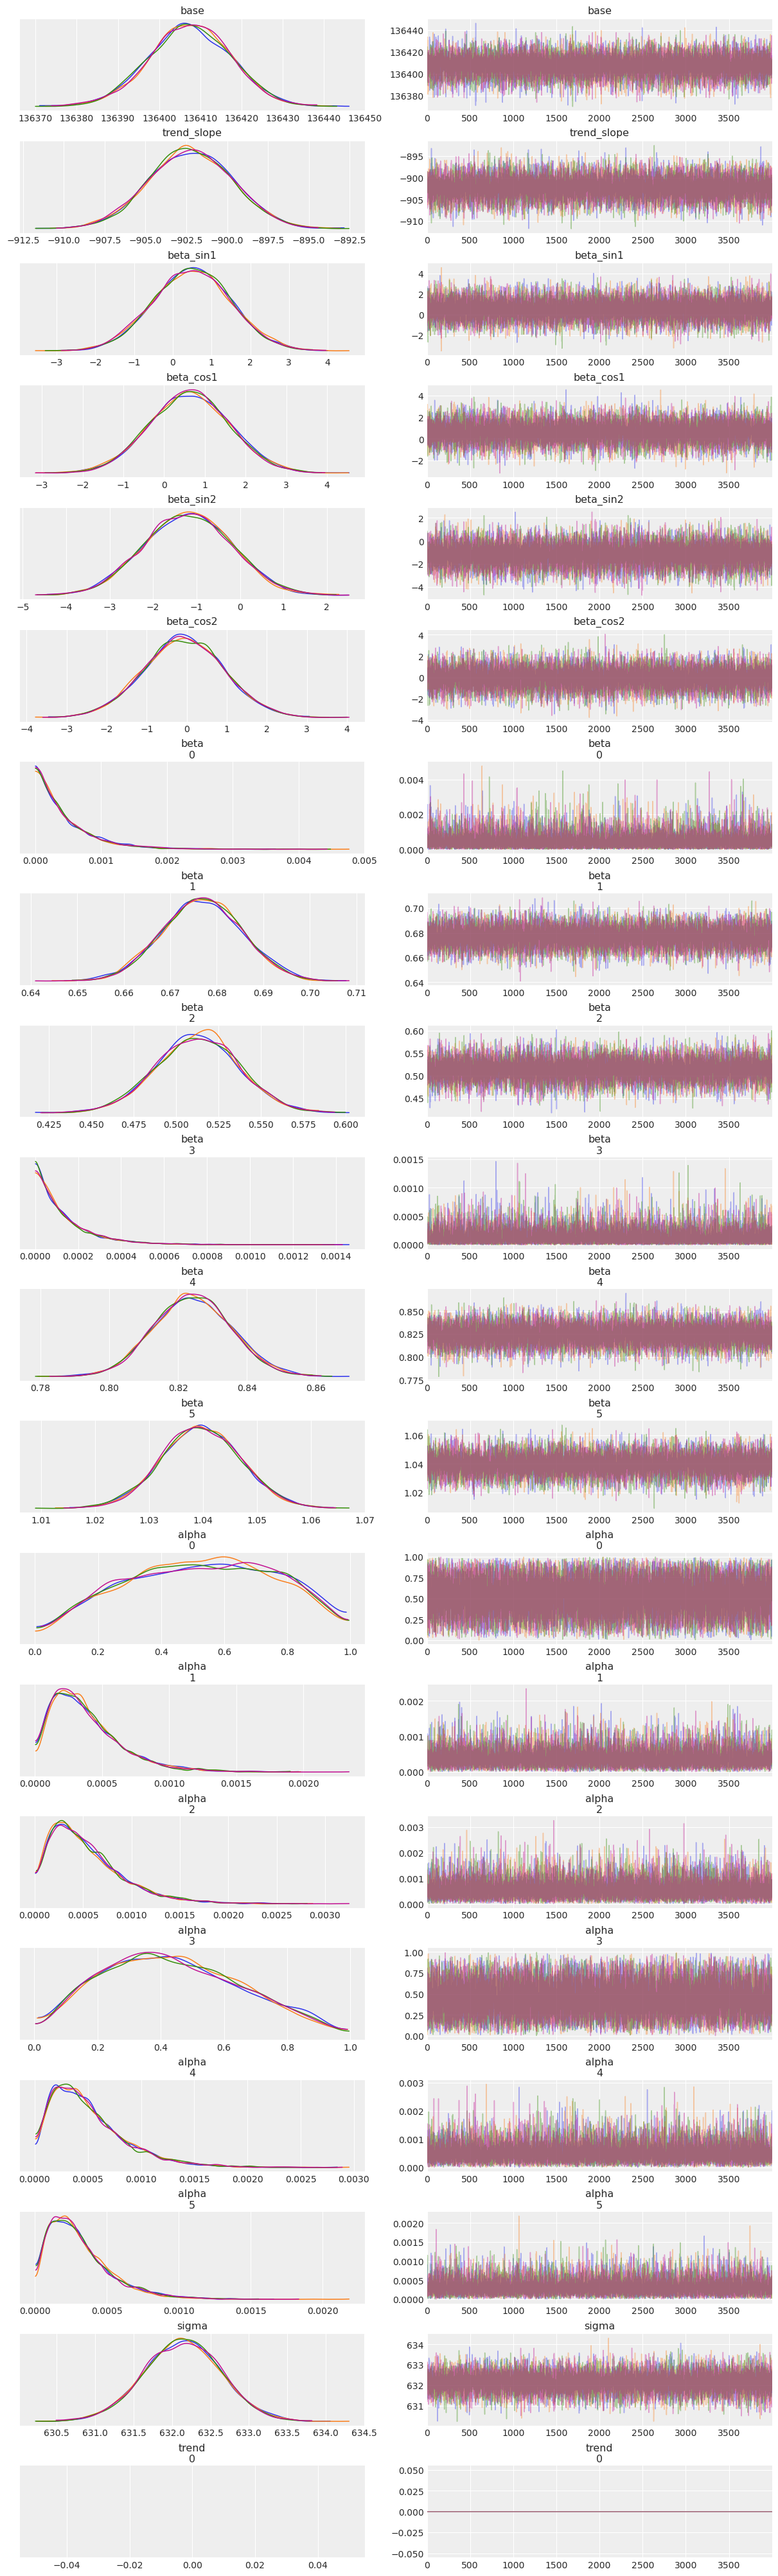

In [19]:
az.style.use("arviz-darkgrid")
az.plot_trace(trace, compact=False);

- Parameters are converged.

In [21]:
with mmm:
    # 1. First generate prior predictive samples
    prior_pred = pm.sample_prior_predictive(samples=1000)
    
    # 2. Then sample from posterior
    trace = pm.sample(draws=1000, tune=1000, cores=4)
    
    # 3. Generate posterior predictive samples
    ppc = pm.sample_posterior_predictive(trace)
    
    # 4. Now we can plot both
    print("Prior Predictive Check:")
    az.plot_ppc(prior_pred, group="prior", kind="kde")
    
    print("\nPosterior Predictive Check:")
    az.plot_ppc(ppc, group="posterior", kind="kde")

Sampling: [alpha, base, beta, beta_cos1, beta_cos2, beta_sin1, beta_sin2, revenue, sigma, trend_slope]


NotImplementedError: Cannot convert None to a tensor variable.

In [ ]:
import arviz as az

# Plot density comparison for key parameters
az.plot_density(
    [trace.prior, trace.posterior],
    var_names=['beta', 'alpha', 'trend_slope'],
    combined=True,
    figsize=(12, 8)
)

In [ ]:
# Prior predictive checks
with model:
    prior_pred = pm.sample_prior_predictive()
    az.plot_ppc(prior_pred)

In [ ]:
print(f"Channel 1 stats:")
print(f"- Avg weekly spend: ${spend_data[:,0].mean():.2f}")
print(f"- Spend/revenue correlation: {np.corrcoef(spend_data[:,0], revenue_data)[0,1]:.2f}")

In [22]:
# Prior predictive checks
with model:
    prior_pred = pm.sample_prior_predictive()
    az.plot_ppc(prior_pred)

# Plot prior/posterior overlap
az.plot_density(
    [prior_pred.prior['beta'], trace.posterior['beta']],
    data_labels=['Prior', 'Posterior']
)

NameError: name 'model' is not defined

In [ ]:
import arviz as az

# Alpha diagnostics
az.plot_forest(trace, var_names=['alpha'], combined=True, hdi_prob=0.94)
plt.title('Adstock Decay Rates (Alpha)')

# Beta diagnostics
az.plot_forest(trace, var_names=['beta'], combined=True, hdi_prob=0.94) 
plt.title('Media Effectiveness (Beta)')

In [ ]:
# Extract posterior trend samples
trend_samples = trace.posterior['trend'].values

# Plot mean trend + uncertainty
plt.figure(figsize=(12, 6))
plt.plot(df['start_of_week'], trend_samples.mean(axis=(0,1)), 
         label='Posterior Mean Trend')
plt.fill_between(df['start_of_week'],
                 np.percentile(trend_samples, 3, axis=(0,1)),
                 np.percentile(trend_samples, 97, axis=(0,1)),
                 alpha=0.3, label='94% HDI')
plt.title('Trend Component with Uncertainty')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

# Get posterior predictive samples
with mmm:
    ppc = pm.sample_posterior_predictive(trace)

# Calculate mean predicted revenue across all samples
predicted_revenue = ppc.posterior_predictive['revenue'].mean(axis=(0, 1)).values

# Create time index for plotting
dates = df['start_of_week']

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(dates, revenue_data, 'b-', label='Actual Revenue')
plt.plot(dates, predicted_revenue, 'r--', label='Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd


In [ ]:
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('MMM_test_data.csv')
df['start_of_week'] = pd.to_datetime(df['start_of_week'], format='%d-%m-%y')

spend_cols = df.filter(like='spend').columns.tolist()
n_channels = len(spend_cols)

# Time features for seasonality
df['week_of_year'] = df['start_of_week'].dt.isocalendar().week
n_weeks = len(df)

# Time index for linear trend 
time_idx = np.arange(n_weeks, dtype='float32')

# Prepare data tensors
spend_data = df[spend_cols].values.astype('float32')
revenue_data = df['revenue'].values.astype('float32')
week_of_year = df['week_of_year'].values.astype('int32')

In [ ]:
def geometric_adstock(spend_series, alpha, l_max):
    # Calculate retention weights
    weights = alpha ** pt.arange(l_max, dtype='float32')
    weights /= pt.sum(weights)  # Normalize
    
    # Pad the spend series with zeros (for lookback)
    padded = pt.concatenate([
        pt.zeros(l_max-1, dtype='float32'),
        spend_series
    ])
    
    # Create indices for all time steps
    time_steps = spend_series.shape[0]
    t = pt.arange(time_steps)  # [0, 1, 2, ..., T-1]
    
    # Create a matrix of all windows at once
    windows = padded[t[:, None] + pt.arange(l_max)]
    
    # Reverse each window and multiply by weights
    adstock = pt.sum(windows[:, ::-1] * weights, axis=1)
    
    return adstock

In [ ]:
def add_flexible_trend(model, time_index, revenue_data):
    """
    Adds a simple but robust linear trend component
    - Allows both positive and negative trends
    - Automatically scales to your data
    - Prevents sampling issues
    """
    # 1. Center time index (critical for stability)
    time_centered = time_index - time_index.mean()
    
    # 2. Calculate empirical growth rate
    total_growth = revenue_data[-1] - revenue_data[0]
    weekly_growth = total_growth / len(revenue_data)
    
    with model:
        # 3. Data-informed slope prior
        slope = pm.Normal('slope',
                        mu=weekly_growth,  # Can be positive or negative
                        sigma=abs(weekly_growth)*2)  # 2x empirical rate
        
        # 4. Intercept centered on mean revenue
        intercept = pm.Normal('trend_intercept',
                            mu=revenue_data.mean(),
                            sigma=revenue_data.std())
        
        # 5. Linear trend
        trend = pm.Deterministic('trend', 
                               intercept + slope * time_centered)
    return trend

In [ ]:
with pm.Model() as mmm:
    # --- Standardize Time Index ---
    time_idx_std = (time_idx - time_idx.mean()) / time_idx.std()
    
    # --- Priors ---
    intercept = pm.Normal('intercept', mu=revenue_data.mean(), sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)  # Wider prior
    
    # --- Linear Trend ---
    trend = pm.Deterministic('trend', slope * time_idx_std)

    trend = add_flexible_trend(mmm, time_idx, revenue_data)
    
    # --- Media Variables ---
    beta = pm.HalfNormal('beta', sigma=10, shape=n_channels)
    alpha = pm.Beta('alpha', alpha=2, beta=2, shape=n_channels)
    
    # --- Seasonality ---
    beta_sin = pm.Normal('beta_sin', mu=0, sigma=1)
    beta_cos = pm.Normal('beta_cos', mu=0, sigma=1)
    freq = 2 * np.pi / 52
    seasonality = beta_sin * pt.sin(freq * week_of_year) + beta_cos * pt.cos(freq * week_of_year)
    
    # --- Adstock Transformation ---
    adstocked = pt.stack([
        geometric_adstock(spend_data[:, i], alpha[i], l_max=8)
        for i in range(n_channels)
    ], axis=1)
    
    # --- Linear Predictor ---
    media_contribution = pt.dot(adstocked, beta)
    mu = intercept + media_contribution + seasonality
    
    # --- Likelihood ---
    sigma = pm.HalfNormal('sigma', sigma=1)
    pm.Normal('revenue', mu=mu, sigma=sigma, observed=revenue_data)
    
    # --- Inference ---
    trace = pm.sample(
        draws=2000,
        tune=1000,
        cores=4,
        target_accept=0.95,
        idata_kwargs={'log_likelihood': True}
    )

In [ ]:
plt.plot(revenue_data)

In [ ]:
import matplotlib.pyplot as plt

# Get posterior predictive samples
with mmm:
    ppc = pm.sample_posterior_predictive(trace)

# Calculate mean predicted revenue across all samples
predicted_revenue = ppc.posterior_predictive['revenue'].mean(axis=(0, 1)).values

# Create time index for plotting
dates = df['start_of_week']

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(dates, revenue_data, 'b-', label='Actual Revenue')
plt.plot(dates, predicted_revenue, 'r--', label='Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import arviz as az
az.plot_trace(trace, var_names=['', 'trend'])

In [ ]:
pm.compare({'with_trend': trace, 'no_trend': trace_no_trend})

In [ ]:
# Plot parameter distributions
az.plot_posterior(trace, var_names=['beta', 'alpha'])

In [ ]:
with mmm:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc, num_pp_samples=100);

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# Load and prepare data
data = pd.read_csv('MMM_test_data.csv', parse_dates=['start_of_week'])
n_weeks = len(data)
n_channels = 7  # From channel_1 to channel_7

# Extract components
revenue_data = data['revenue'].values
spend_data = data[[f'spend_channel_{i}' for i in range(1, n_channels+1)]].values
week_of_year = data['start_of_week'].dt.isocalendar().week.values
time_idx = np.arange(n_weeks)

# Standardize time index for better convergence
time_idx_std = (time_idx - time_idx.mean()) / time_idx.std()

# Handle zero-spend channels (especially channel 6)
# We'll modify the geometric_adstock function to avoid NaNs
def geometric_adstock(spend_series, alpha, l_max=12):
    """Modified to handle zero-spend periods safely"""
    # Calculate retention weights
    weights = alpha ** pt.arange(l_max, dtype='float32')
    weights /= pt.sum(weights)  # Normalize
    
    # Pad the spend series with zeros (for lookback)
    padded = pt.concatenate([
        pt.zeros(l_max-1, dtype='float32'),
        pt.maximum(spend_series, 0)  # Ensure no negative values
    ])
    
    # Create indices for all time steps
    time_steps = spend_series.shape[0]
    t = pt.arange(time_steps)
    
    # Create a matrix of all windows at once
    window_indices = t[:, None] + pt.arange(l_max)
    windows = padded[window_indices]
    
    # Reverse each window and multiply by weights
    adstock = pt.sum(windows[:, ::-1] * weights, axis=1)
    
    return adstock

with pm.Model() as mmm:
    # --- Priors ---
    intercept = pm.Normal('intercept', mu=revenue_data.mean(), sigma=10)
    
    # Media variables
    beta = pm.HalfNormal('beta', sigma=10, shape=n_channels)
    
    # Channel-specific decay - modified for stability
    alpha = pm.Beta('alpha', alpha=2, beta=2, shape=n_channels)
    
    # --- Trend Component ---
    slope = pm.Normal('slope', mu=0, sigma=5)
    trend = pm.Deterministic('trend', slope * time_idx_std)
    
    # --- Seasonality ---
    beta_sin1 = pm.Normal('beta_sin1', mu=0, sigma=1)
    beta_cos1 = pm.Normal('beta_cos1', mu=0, sigma=1)
    beta_sin2 = pm.Normal('beta_sin2', mu=0, sigma=1)
    beta_cos2 = pm.Normal('beta_cos2', mu=0, sigma=1)
    
    freq1 = 2 * np.pi / 52
    freq2 = 2 * np.pi / 26
    
    seasonality = (
        beta_sin1 * pt.sin(freq1 * week_of_year) + 
        beta_cos1 * pt.cos(freq1 * week_of_year) +
        beta_sin2 * pt.sin(freq2 * week_of_year) + 
        beta_cos2 * pt.cos(freq2 * week_of_year)
    )
    
    # --- Adstock Transformation ---
    # Pre-calculate which channels have zero spend (outside model)
    active_channels = [i for i in range(n_channels) if spend_data[:, i].sum() > 0]
    
    # Only apply adstock to channels with spend
    adstocked_list = [
        geometric_adstock(spend_data[:, i], alpha[i], l_max=12)
        for i in active_channels
    ]
    
    # Create full adstocked matrix with zeros for inactive channels
    adstocked = pt.zeros((n_weeks, n_channels), dtype='float32')
    for idx, channel in enumerate(active_channels):
        adstocked = pt.set_subtensor(adstocked[:, channel], adstocked_list[idx])
    
    # --- Media Contribution ---
    media_contribution = pt.dot(adstocked, beta)
    
    # --- Main Equation ---
    mu = intercept + media_contribution + trend + seasonality
    
    # --- Likelihood ---
    sigma = pm.HalfNormal('sigma', sigma=revenue_data.std())
    pm.Normal('revenue', mu=mu, sigma=sigma, observed=revenue_data)
    
    # --- Inference ---
    trace = pm.sample(
        draws=4000,
        tune=2000,
        cores=4,
        target_accept=0.95,
        random_seed=42
    )

In [ ]:
def add_flexible_trend(model, time_index, revenue_data):
    """
    Adds a simple but robust linear trend component
    - Allows both positive and negative trends
    - Automatically scales to your data
    - Prevents sampling issues
    """
    # 1. Center time index (critical for stability)
    time_centered = time_index - time_index.mean()
    
    # 2. Calculate empirical growth rate
    total_growth = revenue_data[-1] - revenue_data[0]
    weekly_growth = total_growth / len(revenue_data)
    
    with model:
        # 3. Data-informed slope prior
        trend_slope = pm.Normal('trend_slope',
                        mu=weekly_growth,  # Can be positive or negative
                        sigma=abs(weekly_growth)*2)  # 2x empirical rate
        
        # 4. Intercept centered on mean revenue
        trend_intercept = pm.Normal('trend_intercept',
                            mu=revenue_data.mean(),
                            sigma=revenue_data.std())
        
        # 5. Linear trend
        trend = pm.Deterministic('trend', 
                               trend_intercept + trend_slope * time_centered)
    return trend